In [14]:
import os
from os import listdir, path
import sys
from threading import Thread, Lock
import time
from imageio import imread, imwrite

from matplotlib import pyplot as plt
from scipy.signal import convolve
from skimage.transform import rescale
import numpy as np
import torch

In [ ]:
# Lado download data given by Prof Geigers here :  https://1drv.ms/u/s!AhnVhbVlzYkKgQU3fIH8gby6yJ2E?e=0Kj2Td 
!unzip KITTI_2015_subset.zip

In [34]:
#@title data handling { form-width: "20%" }

#!/usr/bin/env python
"""Dataloader for siamese training
"""

# convert rgb image to grayscale
def rgb2gray(I):
    return np.dot(I[...,:3], [0.299, 0.587, 0.114])


class KITTIDataset(object):
    def __init__(self, image_dir, disparity_dir=None, downsample=True):
        self.disparity_dir = disparity_dir
        self.downsample = downsample

        left_dir = path.join(image_dir, "image_2")
        right_dir = path.join(image_dir, "image_3")

        self._left_images = sorted([
            path.join(left_dir, img) for img in listdir(left_dir) if "_10." in img
        ])
        self._right_images = sorted([
            path.join(right_dir, img) for img in listdir(right_dir) if "_10." in img
        ])
        assert len(self._left_images) == len(self._right_images)

        if disparity_dir is not None:
            self._disp_images = sorted([
                path.join(disparity_dir, img) for img in listdir(disparity_dir)
            ])
            assert len(self._left_images) == len(self._disp_images)
        else:
            self._disp_images = []

        print('KITTI data loaded (%d images)!' % len(self._left_images))

    def __len__(self):
        return len(self._left_images)

    def __getitem__(self, i):
        img_l = imread(self._left_images[i]).astype(np.float32) / 255.
        img_r = imread(self._right_images[i]).astype(np.float32) / 255.
        
        img_l = rgb2gray(img_l)[..., np.newaxis]
        img_r = rgb2gray(img_r)[..., np.newaxis]

        if self.downsample:
            img_l = rescale(img_l, 0.5, mode='reflect', anti_aliasing=True, multichannel=True)
            img_r = rescale(img_r, 0.5, mode='reflect', anti_aliasing=True, multichannel=True)

        if self.disparity_dir is not None:
            disp = imread(self._disp_images[i]).astype(np.float32) / 256.
        
            if self.downsample:
                H, W = disp.shape
                disp = disp[np.arange(0, H, 2), :] # Downsample first dimension
                disp = disp[:, np.arange(0, W, 2)] # Downsample second dimension
                disp = disp / 2. # Scale values accordingly

            disp[disp <= 0] = -1
    
            return img_l, img_r, disp
        else:
            return img_l, img_r


class PatchProvider(object):
    """Provide training patches"""
    def __init__(self, data, patch_size=(7, 7), N=(4, 10), P=1):
        self._data = data
        self._patch_size = patch_size
        self._N = N
        self._P = P
        self.idxs = None

        self._stop = False
        self._cache = 5
        self._lock = Lock()


    def _get_neg_idx(self, col, W):
        # local copy for convenience
        half_patch = self._patch_size[1]//2
        N = self._N

        neg_offset = np.random.randint(N[0], N[1] + 1)
        neg_offset = neg_offset * np.sign(np.random.rand() - 0.5).astype(np.int32)

        if half_patch <= col + neg_offset < W-half_patch:
            return slice(col+neg_offset-half_patch, col+neg_offset+half_patch+1)
        else:
            return self._get_neg_idx(col, W)

    def _get_pos_idx(self, col, W):
        # local copy for convenience
        half_patch = self._patch_size[1]//2
        P = self._P

        pos_offset = np.random.randint(-P, P+1)
        if half_patch <= col + pos_offset < W-half_patch:
            return slice(col+pos_offset-half_patch, col+pos_offset+half_patch+1)
        else:
            return self._get_pos_idx(col, W)
        
    def random_patch(self):
        # local copy for convenience
        patch_size = self._patch_size
        half_patch = np.array(patch_size)//2
        img_l, img_r, disp = self._data[int(np.random.rand()*len(self._data))]
        H, W = img_l.shape[:2]
        while True:
            half_p = patch_size[0] // 2
            row = np.random.randint(half_p, H - half_p)
            col = np.random.randint(half_p, W - half_p)
            d = disp[row, col]
            if d > 0 and (col - d) > half_p and (col - d) < W - half_p:
                break

        ref_idx = (
            slice(row-half_patch[0], row+half_patch[0]+1),
            slice(col-half_patch[1], col+half_patch[1]+1)
        )
        neg_idx = (
            slice(row-half_patch[0], row+half_patch[0]+1),
            self._get_neg_idx(int(col - disp[row, col]), W)
        )
        pos_idx = (
            slice(row-half_patch[0], row+half_patch[0]+1),
            self._get_pos_idx(int(col - disp[row, col]), W)
        )
        return img_l[ref_idx], img_r[pos_idx], img_r[neg_idx]
        #return img_l[ref_idx], img_r[pos_idx], np.random.random(patch_size + (3,))

    def iterate_batches(self, batch_size):
        # Get a patch to infer the image shape

        patch = self.random_patch()
        channels = patch[0].shape[-1]

        ref_batch = np.zeros(
            (self._cache*batch_size, ) + self._patch_size + (channels,),
            dtype="float32"
        )
        pos_batch = np.zeros_like(ref_batch)
        neg_batch = np.zeros_like(ref_batch)

        # start the thread
        self._thread = Thread(
            target=self.fill_batches,
            args=(ref_batch, pos_batch, neg_batch)
        )
        self._stop = False
        self._thread.start()

        # wait for the buffers to fill
        while True:
            time.sleep(1)
            with self._lock:
                if ref_batch[-1].sum() == 0:
                    pass
                else:
                    break

        # start generating batches
        while True:
            self.idxs = np.random.choice(len(ref_batch), batch_size)
            with self._lock:
                yield torch.Tensor(ref_batch[self.idxs]).cuda(), \
                      torch.Tensor(pos_batch[self.idxs]).cuda(), \
                      torch.Tensor(neg_batch[self.idxs]).cuda()

    def fill_batches(self, ref, pos, neg):
        idx = 0
        while not self._stop:
            patch = self.random_patch()
            with self._lock:
                ref[idx] = patch[0]
                pos[idx] = patch[1]
                neg[idx] = patch[2]
            idx += 1
            idx = idx % len(ref)

    def stop(self):
        self._stop = True
        self._thread.join()

def upsample_disparity_map(disparity_map, output_shape, sampling_factor=2.):
    ''' Upsamples the disparity map to the provided output shape.

    Please note that when upsampling the disparity, the value need to be adjusted
    with regard to the downsampling factor of the images for which the disparity
    was calculated. For example, when we half the resolution before calculating
    the disparity, we need to multiply the disparity by 2 if we want to obtain
    the disparity map for the original size. 
    
    Arguments:
    ----------
        disparity_map: disparity map 
        output_shape: desired output shape
        sampling_factor: sampling factor by which the upsampled disparity map is
            multiplied (default: 2.)
    '''
    #disparity_map = imresize(disparity_map, output_shape, interp='nearest')
    disparity_map = disparity_map * sampling_factor
    return disparity_map


def return_accuracy(pred_disparity, gt_disparity, threshold=1.5):
    """ Returns the accuracy for the predicted and GT disparity maps.

    Arguments:
    ----------
        pred_disparity: predicted disparity map 
        gt_disparity: ground truth disparity map 
        threshold: threshold value defining which maximum difference should be considered correct (default 3)
        half_resolution: whether the disparity was calculated on half resolution images. If so, the predicted 
            disparity map needs to be upsampled and multiplied by 2 before comparing against the ground truth
    """

    diff = np.abs(pred_disparity - gt_disparity)
    mask = gt_disparity > 0.

    diff[mask == 0] = 0.

    correct = (np.abs(gt_disparity[mask] - pred_disparity[mask]) < threshold).sum()
    total = mask.sum()    
    acc = correct / total

    return diff, acc


KITTI data loaded (5 images)!


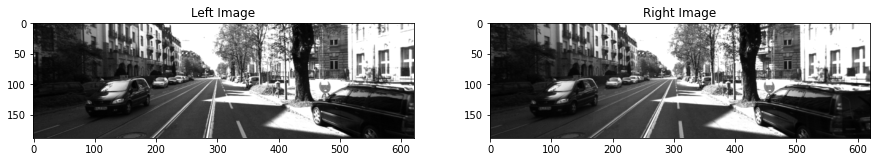

In [35]:
input_dir = './KITTI_2015_subset'
window_size = 3
max_disparity = 50
out_dir = os.path.join(
    './output/handcrafted_stereo', 'window_size_%d' % window_size
)

# Create output directory
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
    
# Load dataset
dset = KITTIDataset(os.path.join(input_dir, "data_scene_flow/testing/"))

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(121)
ax1.imshow(dset[0][0].squeeze(), cmap='gray')
ax1.title.set_text('Left Image')
ax2 = fig.add_subplot(122)
ax2.imshow(dset[0][1].squeeze(), cmap='gray')
ax2.title.set_text('Right Image')
plt.show()

block matching algorithm implementation just to compare the its results with siamese net results

In [36]:
def add_padding(I, padding):
    """
    Adds zero padding to an RGB or grayscale image.

    Args:
        I (np.ndarray): HxWx? numpy array containing RGB or grayscale image
    
    Returns:
        P (np.ndarray): (H+2*padding)x(W+2*padding)x? numpy array containing zero padded image
    """
    if len(I.shape) == 2:
        H, W = I.shape
        padded = np.zeros((H+2*padding, W+2*padding), dtype=np.float32)
        padded[padding:-padding, padding:-padding] = I
    else:
        H, W, C = I.shape
        padded = np.zeros((H+2*padding, W+2*padding, C), dtype=I.dtype)
        padded[padding:-padding, padding:-padding] = I

    return padded


def sad(image_left, image_right, window_size=3, max_disparity=50):
    """
    Compute the sum of absolute differences between image_left and image_right.

    Args:
        image_left (np.ndarray): HxW numpy array containing grayscale right image
        image_right (np.ndarray): HxW numpy array containing grayscale left image
        window_size: window size (default 3)
        max_disparity: maximal disparity to reduce search range (default 50)
    
    Returns:
        D (np.ndarray): HxW numpy array containing the disparity for each pixel
    """

    D = np.zeros_like(image_left)

    # add zero padding
    padding = window_size // 2
    image_left = add_padding(image_left, padding).astype(np.float32)
    image_right = add_padding(image_right, padding).astype(np.float32)
    
    height = image_left.shape[0]
    width = image_left.shape[1]

    # for each row
    for h in range(height - window_size + 1):        
        # for each column
        for w in range(width - window_size + 1):
            # set cost for each column to infinity
            cost = np.ones(max_disparity+1) * np.inf
            
            # for each disparity [0, max_disparity]
            for d in range(0, max_disparity+1):
                # get column shifted by disparity d
                shifted = w - d
                
                # check validity
                if shifted < 0:
                    continue

                # extract patch image_left
                patch_image_left = image_left[h:h+window_size, w:w+window_size]
                
                # extract patch image_right shifted by disparity d (shifted)
                patch_image_right = image_right[h:h+window_size, shifted:shifted+window_size]
                
                # compute absolute difference
                sad = np.sum(np.abs(patch_image_left - patch_image_right))

                # sum absolute difference                
                cost[d] = sad
                # -------------------------------------    
            # find the minimum cost
            D[h, w] = np.argmin(cost)
    return D


def sad_convolve(image_left, image_right, window_size=3, max_disparity=50):
    """
    Compute the sum of absolute differences between image_left and image_right
    by using a mean filter.

    Args:
        image_left (np.nfarray): HxW numpy array containing grayscale right image
        image_right (np.nfarray): HxW numpy array containing grayscale left image
        window_size: window size (default 3)
        max_disparity: maximal disparity to reduce search range (default 50)
    
    Returns:
        D (np.ndarray): HxW numpy array containing the disparity for each pixel
    """

    h, w = image_left.shape

    kernel = np.ones((window_size, window_size)) / (window_size ** 2)

    sad = np.zeros((h, w, max_disparity + 1))
    img_r = image_right
    for d in range(max_disparity + 1):
        # Slide right image to the right
        if d > 0:
            img_r = np.zeros_like(image_right)
            img_r[:, d:] = image_right[:, :-d]
        
        # Calculate difference image and convolve
        img_difference = np.abs(image_left - img_r)
        img_response = convolve(img_difference, kernel, mode='same', method='direct')

        sad[:, :, d] = img_response

    # Find argmins which are disparity values
    D = np.argmin(sad, axis=2)
    return D


In [37]:
def visualize_disparity(disparity, im_left, im_right, title='Disparity Map', max_disparity=50):
    """
    Generates a visualization for the disparity map.

    Args:
        disparity (np.array): disparity map
        title: plot title
        out_file: output file path
        max_disparity: maximum disparity
    """

    # visualize stereo pair
    fig = plt.figure(figsize=(15, 5))
    plt.title(title)
    plt.axis('off')
    ax1 = fig.add_subplot(211)
    ax1.imshow(im_left, cmap='gray')
    
    # visualize disparity
    ax2 = fig.add_subplot(212)
    im = ax2.imshow(disparity, cmap='Spectral', vmin=0, vmax=max_disparity)

    plt.tight_layout()
    plt.show()

In [ ]:
for i in range(len(dset)):
        # Load left and right images
        im_left, im_right  = dset[i]
        im_left, im_right = im_left.squeeze(-1), im_right.squeeze(-1)

        # Calculate disparity
        D = sad(im_left, im_right, window_size=window_size, max_disparity=max_disparity)

        # Define title for the plot
        title = 'Disparity map for image %04d with block matching (window size %d)' % (i, window_size)
        # Define output file name and patch
        file_name = '%04d_w%03d.png' % (i, window_size)
        out_file_path = os.path.join(out_dir, file_name)

        # Visualize the disparty and save it to a file
        visualize_disparity(D, im_left, im_right, title=title, max_disparity=max_disparity)

Siamese Network implementation

In [ ]:
class StereoMatchingNetwork(torch.nn.Module):
    def __init__(self):
        """
        Implementation of the network layers.
        Layer output tensor size: (batch_size, n_features, height - 8, width - 8)
        """
        super().__init__()
        gpu = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        hidden_size = 64
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=hidden_size, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3)
        ).to(gpu)

    def forward(self, X):
        """ 
        The forward pass of the network. Returns the features for a given image patch.

        Args:
            X (torch.Tensor): image patch of shape (batch_size, height, width, n_channels)

        Returns:
            features (torch.Tensor): predicted normalized features of the input image patch X,
                               shape (batch_size, height - 8, width - 8, n_features)
        """

        X = X.permute(0, 3, 1, 2)
        X = self.conv_layers(X)
        features = torch.nn.functional.normalize(X, dim=1, p=2)
        return features.permute(0, 2, 3, 1)

In [ ]:
def calculate_similarity_score(infer_similarity_metric, Xl, Xr):
    """
    Computes the similarity score for two stereo image patches.

    Args:
        infer_similarity_metric (torch.nn.Module):  pytorch module object
        Xl (torch.Tensor): tensor holding the left image patch
        Xr (torch.Tensor): tensor holding the right image patch

    Returns:
        score (torch.Tensor): the similarity score of both image patches which is the dot product of their features
    """

    # run the forward pass of the network for both images
    Fl = infer_similarity_metric(Xl)
    Fr = infer_similarity_metric(Xr)
    # the similarity score is the dot product of both feature tensors
    return torch.sum(Fl * Fr, dim=-1).squeeze()

In [ ]:
def hinge_loss(score_pos, score_neg, label):
    """
    Computes the hinge loss for the similarity of a positive and a negative example.

    Args:
        score_pos (torch.Tensor): similarity score of the positive example
        score_neg (torch.Tensor): similarity score of the negative example
        label (torch.Tensor): the true labels

    Returns:
        avg_loss (torch.Tensor): the mean loss over the patch and the mini batch
        acc (torch.Tensor): the accuracy of the prediction
    """
    # Calculate the hinge loss max(0, margin + s_neg - s_pos)
    loss = torch.max(0.2 + score_neg - score_pos, torch.zeros_like(score_pos))

    # Obtain the mean over the patch and the mini batch
    avg_loss = torch.mean(loss)

    # Calculate the accuracy
    similarity = torch.stack([score_pos, score_neg], dim=1)
    labels = torch.argmax(label, dim=1)
    predictions = torch.argmax(similarity, dim=1)
    acc = torch.mean((labels == predictions).float())

    return avg_loss, acc


def training_loop(infer_similarity_metric, patches, optimizer, iterations=1000, batch_size=128):
    '''
    Runs the training loop of the siamese network.
    
    Args:
        infer_similarity_metric (obj): pytorch module
        patches (obj): patch provider object
        optimizer (obj): optimizer object
        iterations (int): number of iterations to perform
        batch_size (int): batch size
    '''

    loss_list = []
    try:
        print("Starting training loop.")
        for idx, batch in zip(range(iterations), patches.iterate_batches(batch_size)):
            # Extract the batches and labels
            Xl, Xr_pos, Xr_neg = batch
            # uncomment if you don't have a gpu
            # Xl, Xr_pos, Xr_neg = Xl.cpu(), Xr_pos.cpu(), Xr_neg.cpu()
            
            # use this line if you have a gpu
            label = torch.eye(2).cuda()[[0]*len(Xl)]  # label is always [1, 0]
            # use this line if you don't have a gpu
            # label = torch.eye(2)[[0]*len(Xl)]  # label is always [1, 0]

            # calculate the similarity score
            score_pos = calculate_similarity_score(infer_similarity_metric, Xl, Xr_pos)
            score_neg = calculate_similarity_score(infer_similarity_metric, Xl, Xr_neg)
            # compute the loss and accuracy
            loss, acc = hinge_loss(score_pos, score_neg, label)

            # compute the gradients
            optimizer.zero_grad()
            loss.backward()
            # let the optimizer perform one step and update the weights
            optimizer.step()

            # Append loss to list
            loss_list.append(loss.item())

            if idx % 50 == 0:
                print("Loss (%04d it):%.04f \tAccuracy: %0.3f" % (idx, loss, acc))
    finally:
        patches.stop()
        print("Finished training!")

In [ ]:
# Fix random seed for reproducibility        
np.random.seed(7)
torch.manual_seed(7)

# Shortcuts for directories
model_out_dir = os.path.join(out_dir, 'model')
model_file = os.path.join(model_out_dir, "model.t7")

# Hyperparameters
training_iterations = 1000
batch_size= 128
learning_rate = 3e-4
patch_size = 9
padding = patch_size // 2
max_disparity = 50

# Check if output directory exists and if not create it
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
if not os.path.exists(model_out_dir):
    os.makedirs(model_out_dir)

# Create dataloader for KITTI training set
dataset = KITTIDataset(
    os.path.join(input_dir, "data_scene_flow/training/"),
    os.path.join(input_dir, "data_scene_flow/training/disp_noc_0"),
)
# Load patch provider
patches = PatchProvider(dataset, patch_size=(patch_size, patch_size))

# Initialize the network
infer_similarity_metric = StereoMatchingNetwork()
# Set to train
infer_similarity_metric.train()
# uncomment if you don't have a gpu
# infer_similarity_metric.to('cpu')
optimizer = torch.optim.SGD(infer_similarity_metric.parameters(), lr=learning_rate, momentum=0.9)

# Start training loop
training_loop(infer_similarity_metric, patches, optimizer,
                iterations=1000, batch_size=128)

KITTI data loaded (30 images)!
Starting training loop.
Loss (0000 it):0.1852 	Accuracy: 0.828
Loss (0050 it):0.1806 	Accuracy: 0.844
Loss (0100 it):0.1643 	Accuracy: 0.812
Loss (0150 it):0.1262 	Accuracy: 0.859
Loss (0200 it):0.1084 	Accuracy: 0.867
Loss (0250 it):0.1007 	Accuracy: 0.836
Loss (0300 it):0.0861 	Accuracy: 0.875
Loss (0350 it):0.0548 	Accuracy: 0.922
Loss (0400 it):0.0727 	Accuracy: 0.867
Loss (0450 it):0.0668 	Accuracy: 0.914
Loss (0500 it):0.0628 	Accuracy: 0.922
Loss (0550 it):0.0578 	Accuracy: 0.922
Loss (0600 it):0.0612 	Accuracy: 0.945
Loss (0650 it):0.0438 	Accuracy: 0.953
Loss (0700 it):0.0513 	Accuracy: 0.922
Loss (0750 it):0.0437 	Accuracy: 0.969
Loss (0800 it):0.0468 	Accuracy: 0.945
Loss (0850 it):0.0404 	Accuracy: 0.961
Loss (0900 it):0.0612 	Accuracy: 0.914
Loss (0950 it):0.0403 	Accuracy: 0.945
Finished training!


In [ ]:
def compute_disparity_CNN(infer_similarity_metric, img_l, img_r, max_disparity=50):
    """
    Computes the disparity of the stereo image pair.

    Args:
        infer_similarity_metric:  pytorch module object
        img_l: tensor holding the left image
        img_r: tensor holding the right image
        max_disparity (int): maximum disparity

    Returns:
        D: tensor holding the disparity
    """
    # get the image features by applying the similarity metric
    Fl = infer_similarity_metric(img_l[None])
    Fr = infer_similarity_metric(img_r[None])

    # images of shape B x H x W x C
    B, H, W, C = Fl.shape
    # Initialize the disparity
    disparity = torch.zeros((B, H, W)).int()
    # Initialize current similarity to -infimum
    current_similarity = torch.ones((B, H, W)) * -np.inf

    # Loop over all possible disparity values
    Fr_shifted = Fr
    for d in range(max_disparity + 1):
        if d > 0:
            # initialize shifted right image
            Fr_shifted = torch.zeros_like(Fr)
            # insert values which are shifted to the right by d
            Fr_shifted[:, :, d:] = Fr[:, :, :-d]

        # Calculate similarities
        sim_d = torch.sum(Fl * Fr_shifted, dim=3)
        # Check where similarity for disparity d is better than current one
        indices_pos = sim_d > current_similarity
        # Enter new similarity values
        current_similarity[indices_pos] = sim_d[indices_pos]
        # Enter new disparity values
        disparity[indices_pos] = d

    return disparity

use this to compare results from siamese nets and block matching

In [ ]:
# Set network to eval mode
infer_similarity_metric.eval()
infer_similarity_metric.to('cpu')

# Load KITTI test split
dataset = KITTIDataset(os.path.join(input_dir, "data_scene_flow/testing/"))
# Loop over test images
for i in range(len(dataset)):
    print('Processing %d image' % i)
    # Load images and add padding
    img_left, img_right = dataset[i]
    img_left_padded, img_right_padded = add_padding(img_left, padding), add_padding(img_right, padding)
    img_left_padded, img_right_padded = torch.Tensor(img_left_padded), torch.Tensor(img_right_padded)

    disparity_map = compute_disparity_CNN(
        infer_similarity_metric, img_left_padded, img_right_padded, max_disparity=max_disparity
    )
    # Define title for the plot
    title = 'Disparity map for image %04d with SNN \
        (training iterations %d, batch size %d, patch_size %d)' % (i, training_iterations, batch_size, patch_size)
    visualize_disparity(disparity_map.squeeze(), img_left.squeeze(), img_right.squeeze(), title, max_disparity=max_disparity)
